# Imports

In [14]:
# Load modules and set-up test problem
import sys
# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D
from cuqi.distribution import Gaussian, JointDistribution, GMRF
from cuqi.implicitprior import RegularizedGaussian
from cuqi.experimental.mcmc import RegularizedLinearRTO, MH, LinearRTO
from cuqi.geometry import StepExpansion

# Set seed
np.random.seed(24601)


# Set-up the problem

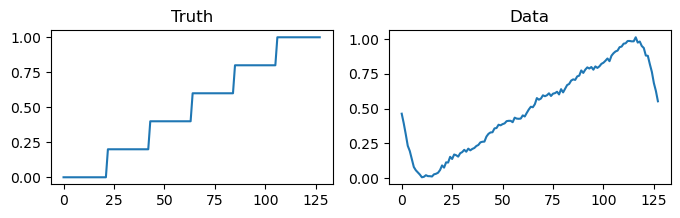

In [15]:
n = 128

x_true = np.zeros(n)

num_steps = 6
step_width = int(n/num_steps)
step_size = 1.0/(num_steps-1)
for i in range(1,num_steps):
    x_true[i*step_width+1:] += step_size

A, y_data, info = Deconvolution1D(dim=n, phantom=x_true, PSF_param = 5).get_components()

plt.figure(figsize = (8,2))
plt.subplot(1,2,1)
info.exactSolution.plot()
plt.title("Truth")

plt.subplot(1,2,2)
y_data.plot()
plt.title("Data")

plt.savefig("figures/staircase/stairs_data.pdf")

# Unconstrained

Sample:   0%|          | 0/5000 [00:00<?, ?it/s, acc rate: 100.00%]

Sample: 100%|██████████| 5000/5000 [00:21<00:00, 229.08it/s, acc rate: 100.00%]


Plotting 5 randomly selected samples


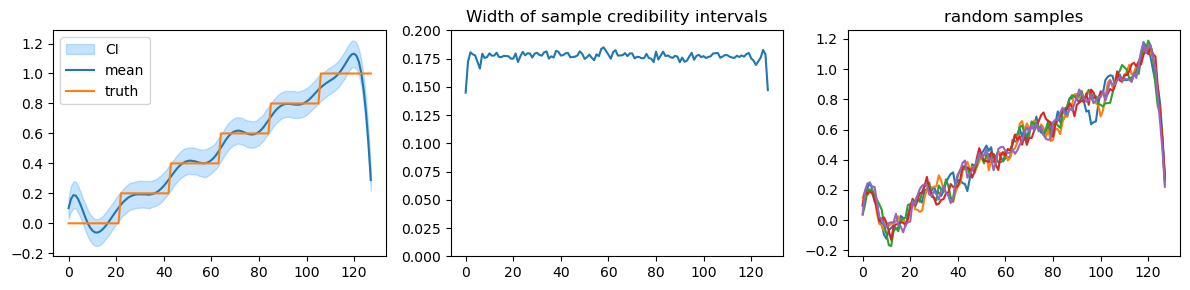

In [16]:
num_samples = 5000
num_burnin = 100
thinning = 1

x = GMRF(np.zeros(n), prec = 500)
y  = Gaussian(A@x, 0.001)

joint = JointDistribution(x, y)
posterior = joint(y=y_data)


sampler = LinearRTO(posterior) 
sampler.sample(num_samples, num_burnin)

samples = sampler.get_samples().burnthin(num_burnin, thinning)

plt.figure(figsize = (12,3))
plt.subplot(1,3,1)
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["CI", "mean", "truth"])

plt.subplot(1,3,2)
samples.plot_ci_width()
plt.ylim((0, 0.2))

plt.subplot(1,3,3)
samples.plot()
plt.title("random samples")

plt.tight_layout()
plt.savefig("figures/staircase/stairs_results_gaussian.pdf")

# Monotonically constrained Gaussian

In [17]:
num_samples = 5000
num_burnin = 10
thinning = 1

x = RegularizedGaussian(np.zeros(n), prec = 10, constraint = "increasing")
y = Gaussian(A@x, 0.001)

posterior = JointDistribution(x, y)(y=y_data)

sampler = RegularizedLinearRTO(posterior,
                                    maxit=100,
                                    penalty_parameter = 100) 
sampler.sample(num_samples + num_burnin)


samples = sampler.get_samples().burnthin(num_burnin, thinning)

Sample: 100%|██████████| 5010/5010 [02:24<00:00, 34.75it/s, acc rate: 100.00%]


Plotting 5 randomly selected samples


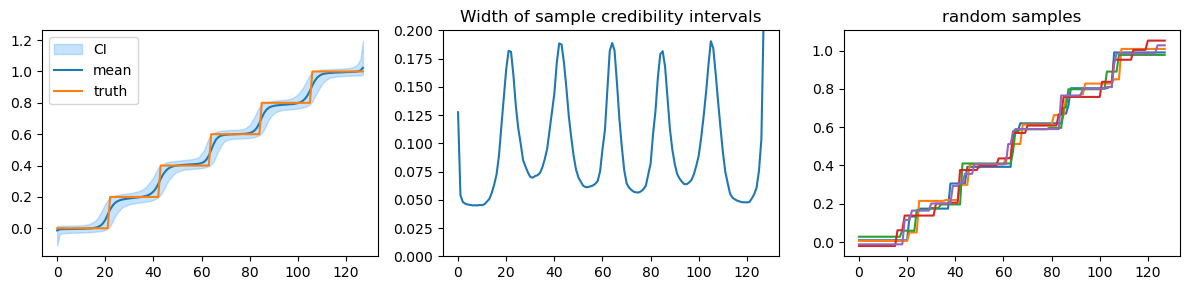

In [18]:
plt.figure(figsize = (12, 3))

plt.subplot(1,3,1)
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["CI","mean", "truth"])

plt.subplot(1,3,2)
samples.plot_ci_width()
plt.ylim((0, 0.2))

plt.subplot(1,3,3)
samples.plot()
plt.title("random samples")

plt.tight_layout()
plt.savefig("figures/staircase/stairs_results.pdf")

# Step expansion

In [19]:
num_samples = 50000
num_burnin = 1000
thinning = 1

num_steps = 12
geometry = StepExpansion(np.linspace(0,127,n), num_steps)
A.domain_geometry = geometry
x = Gaussian(np.zeros(num_steps), cov = 1)
y = Gaussian(A@x, 0.001)

posterior = JointDistribution(x, y)(y=y_data)

sampler = MH(posterior, scale = 0.01)
sampler.sample(num_samples + num_burnin)


samples = sampler.get_samples().burnthin(num_burnin, thinning)

Sample: 100%|██████████| 51000/51000 [03:09<00:00, 269.13it/s, acc rate: 23.73%]


Selecting 5 randomly chosen variables


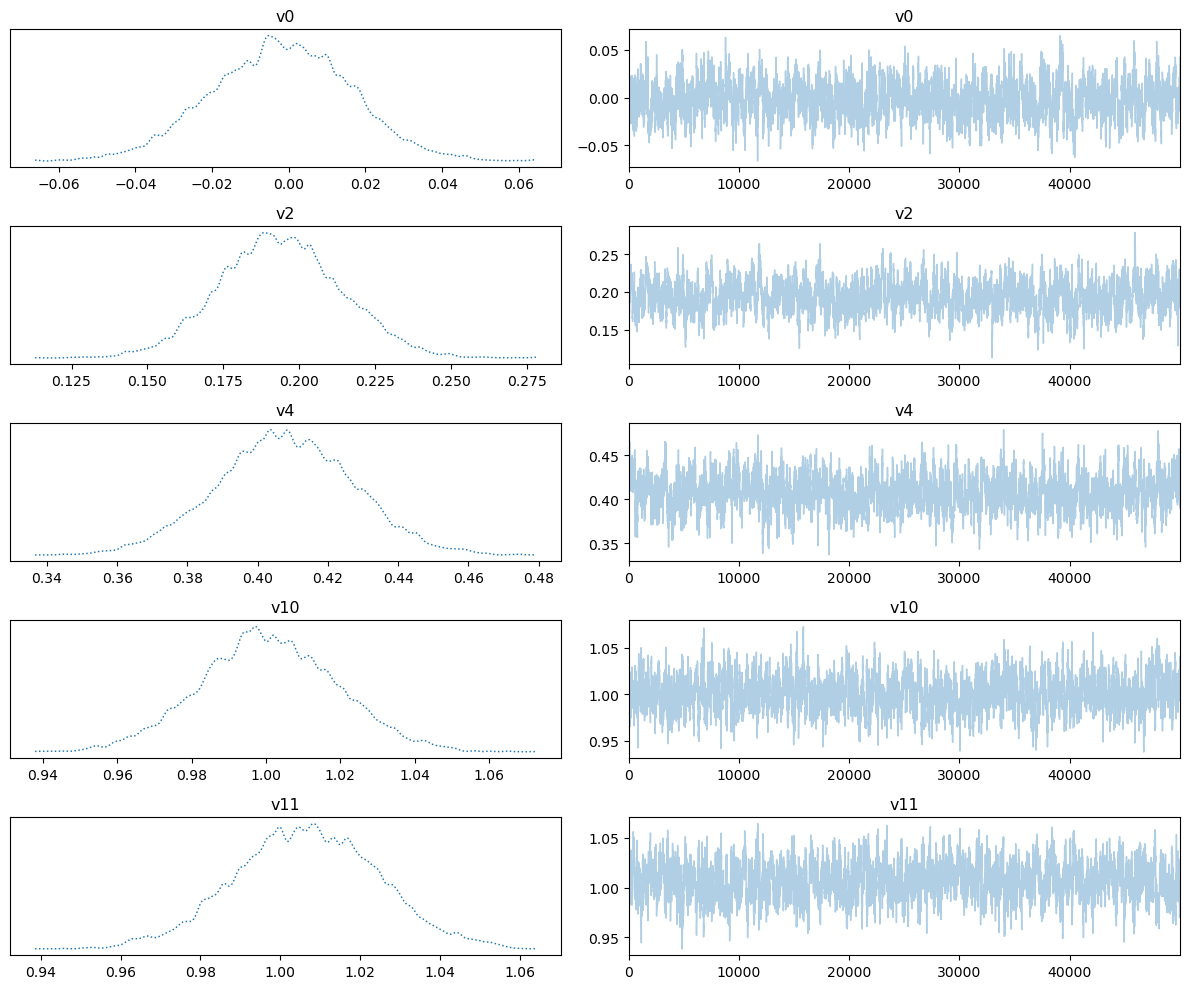

In [20]:
samples.plot_trace();

Plotting 5 randomly selected samples


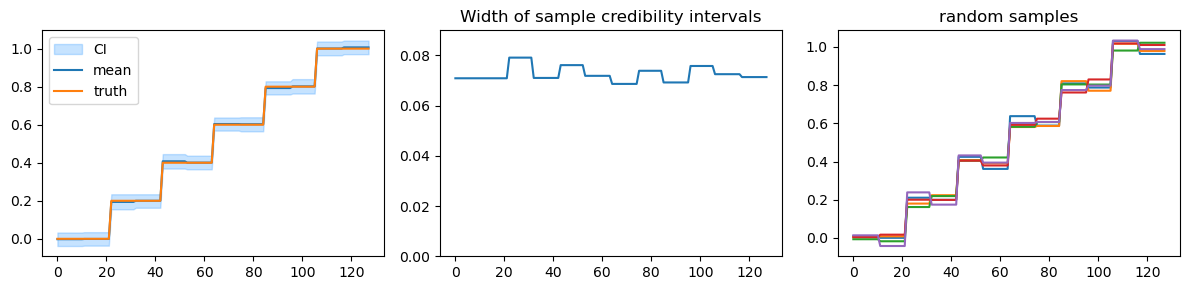

In [21]:
plt.figure(figsize = (12, 3))

plt.subplot(1,3,1)
samples.plot_ci()
plt.plot(np.linspace(0,127,n), info.exactSolution)
plt.legend([ "CI", "mean", "truth"])

plt.subplot(1,3,2)
samples.plot_ci_width()
plt.ylim((0, 0.09))

plt.subplot(1,3,3)
samples.plot()
plt.title("random samples")

plt.tight_layout()
plt.savefig("figures/staircase/stairs_stepexpansion.pdf")